### Plot the full impacts at Level 1a
including effects from improved capabilities via envelope improvements

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from dr_path.db import models, io
from dr_path import settings
from dr_path.plotting import plots
#%matplotlib notebook

In [2]:
region='NENG'
dr_type='shift'
indir = "/mnt/sdb/bgerke_cache/bto_ee_dr_cache/dr_path_inputs_resstock_comstock_2016/"



In [3]:
#Mapping for WS to city name
city_tweak = {'Midland Midland':'Midland', 'Lubbock Lubbock':'Lubbock', 'Dallas Fort':'Dallas', 
              'Shreveport Regional':'Shreveport, LA', 'Abilene Municipal':'Abilene', 
              'Amarillo Intl':'Amarillo',
              'Angelina Co':'Angelina', 'Austin Mueller':'Austin', 'Brownsville Intl':'Brownsville',
              'Houston Intercontin':'Houston',
              'Victoria Victoria':'Victoria', 'Waco Rgnl':'Waco', 
              'Arcata 725945':'Arcata',
              'Barstow Daggett': 'Barstow', 'Bakersfield Meadows':'Bakersfield', 
              'Fresno Air':'Fresno', 'Reno Cannon':'Reno',
              'Sacramento Executiv': 'Sacramento',
              'Hartford Bradley': 'Hartford, CT', 
              'Bridgeport Igor': 'Bridgeport, CT',
              'Boston Logan': 'Boston, MA', 
              'Portland Intnl': 'Portland, ME', 
              'Concord Municipal': 'Concord, NH', 
              'Burlington Intl': 'Burlington, VT',
              'Providence Green': 'Providence, RI',
              'Albany County': 'Albany, NY'}

upg_name_map = {1: 'Equipment only',
                2: 'Controls only',
                3: 'Envelope only',
                4: 'Cont. + env.',
                5: 'All measures'}

#Lists of cities to keep
if region == 'CAMX':
    cities=['Arcata', 'Barstow', 'Fresno', 
            'Los Angeles', 'Sacramento', 'San Diego', 'San Francisco']
elif region=='ERCT':
    cities = ['Abilene','Amarillo','Brownsville', 'Corpus Christi',  
              'Dallas', 'Houston', 'Shreveport, LA']
elif region=='NENG':
    cities = ['Hartford, CT', 'Providence, RI', 'Boston, MA', 'Albany, NY',
              'Burlington, VT', 'Concord, NH', 'Portland, ME']
    
    
region_mapping = {'CAMX': 'California', 
                  'ERCT': 'Texas',
                  'NENG': 'New England'}

test_year = 2016
test_year

2016

In [4]:

def extract_city(pw):
    
    pw['city'] = pw['cluster'].str.split('_').str[2].str.split('.').str[0:2]
    pw['city'] = pw['city'].str[0].str.cat(pw['city'].str[1], sep= ' ')
    for c in city_tweak.keys():
        pw.loc[pw['city']==c,'city'] = city_tweak[c]
    
    return pw

def get_pws_and_resource(dem, tou, ren, ts, dr_type='shed', btype='Single-Family Detached'):
    pws = io.get_pathways_df_at_price(dem,tou,ren,ts, 800., 
                                      dr_type=dr_type, year=test_year, 
                                      cost_frame='gross', 
                                      extra_fields=[models.SiteInstallation.end_use_customer_count, 
                                                    models.SiteInstallation.cluster_customer_count,
                                                    models.SiteInstallation.dr_resource_kw_site,
                                                   models.SiteInstallation.building_type])
    assert (pws['dr_resource_kw_site'] == pws['dr_resource_kw_cluster'].div(pws['end_use_customer_count'])).all()
    
    #Compute resource for an AVERAGE site (including zeros)
    pws['dr_resource_kw_avg_site'] = pws['dr_resource_kw_cluster'].div(pws['cluster_customer_count'])
    #Extract city name
    pws = extract_city(pws)
    resource = pws.loc[pws['building_type']==btype].groupby(
        ['city', 'end_use'])['dr_resource_kw_avg_site'].max().reset_index().groupby(
        ['city'])['dr_resource_kw_avg_site'].sum()
    return pws, resource



<AxesSubplot:ylabel='procurement_price'>

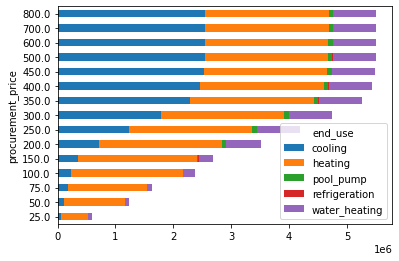

In [5]:
try:
    models.database.close()
except:
    pass


db_file = os.path.join(indir,region,'dr_path_{r}.db'.format(r=region))
models.database.init(db_file)
#db_file = os.path.join(indir,region,'dr_path_{r}_0.db'.format(r=region))
models.database.init(db_file)

models.database.connect()
dem = models.DemandScenario.get(id=1)
tou = models.TOUImpactScenario.get(id=1)
ren = models.RenewableScenario.select().where(
    models.RenewableScenario.weather ==dem.weather)[0]
ts = models.TechnologyScenario.get(name='Base')

pw_base_shed, resource_base_shed = get_pws_and_resource(dem, tou, ren, ts, dr_type='shed')
pw_base_shift, resource_base_shift = get_pws_and_resource(dem, tou, ren, ts, dr_type='shift')

sup = io.get_supply_curve(dem, tou, ren, ts, year=2016, dr_type='shift', disaggregate_by='end_use')
sup.plot.barh(stacked=True)

In [6]:


resource_deltas_shed = pd.DataFrame()
resource_deltas_shift = pd.DataFrame()
for u in [1,2,3,4,5]:
    models.database.close
    db_file = os.path.join(indir,region,'dr_path_{r}_{u}.db'.format(r=region, u=u))
    models.database.init(db_file)

    models.database.connect()
    dem = models.DemandScenario.get(id=1)
    tou = models.TOUImpactScenario.get(id=1)
    ren = models.RenewableScenario.select().where(
        models.RenewableScenario.weather ==dem.weather)[0]
    ts = models.TechnologyScenario.get(name='Base')
    pw_upg_shed, resource_upg_shed = get_pws_and_resource(dem, tou, ren, ts, dr_type='shed')
    pw_upg_shift, resource_upg_shift = get_pws_and_resource(dem, tou, ren, ts, dr_type='shift')
    
    resource_deltas_shed[u] = resource_upg_shed.sub(resource_base_shed)
    resource_deltas_shift[u] = resource_upg_shift.sub(resource_base_shift)

resource_deltas_shed = resource_deltas_shed.rename(
        index=city_tweak, columns=upg_name_map)
resource_deltas_shift = resource_deltas_shift.rename(
        index=city_tweak, columns=upg_name_map)

resource_deltas_shift

OperationalError: no such table: demandscenario

In [32]:
incl_cols = resource_deltas_shed.columns[~resource_deltas_shed.columns.str.contains('All')]
colors = ['darkcyan', 'firebrick', 'mediumblue', 'darkviolet', 'dimgray']

/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/bgerke/.local/share/virtualenvs/dr-path-dTyjfFZm/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.sta

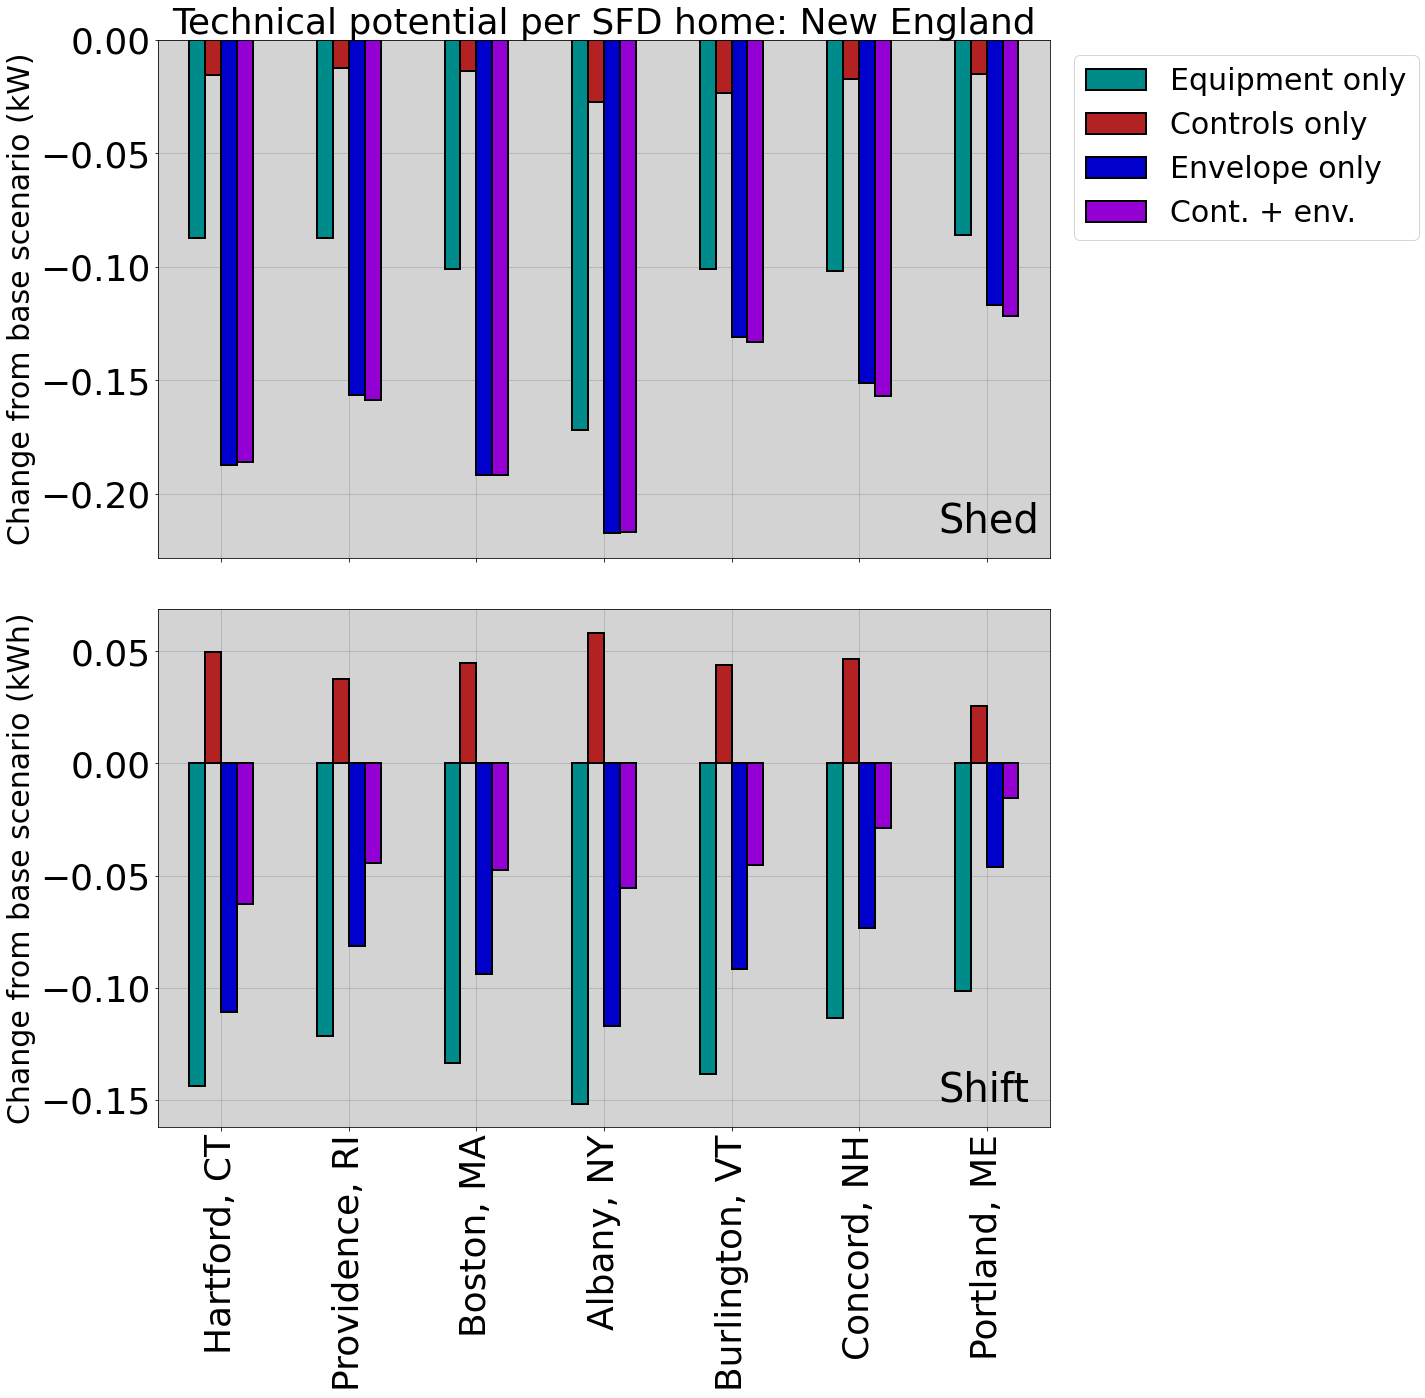

In [33]:
#Create figure
fig,axs = plt.subplots(2,1, figsize=[16,20], sharex=True)

ax=axs[0]
resource_deltas_shed[incl_cols].reindex(cities).plot(kind='bar', 
                                                     edgecolor='k', color=colors,
                                                     linewidth=2, fontsize=36, grid=True,ax=ax, legend=False)
ax.set_axisbelow(True)
ax.set_facecolor("lightgray")
ax.set_ylabel(
        "Change from base scenario (kW)", 
        fontsize=30)
ax.set_xlabel('')
ax.text(0.875,0.05,'Shed', transform=ax.transAxes, fontsize=40)

ax=axs[1]
resource_deltas_shift[incl_cols].reindex(cities).plot(kind='bar', edgecolor='k', color=colors,
                                           linewidth=2, fontsize=36, grid=True,ax=ax, legend=False)
ax.set_axisbelow(True)
ax.set_facecolor("lightgray")
ax.set_ylabel(
        "Change from base scenario (kWh)", 
        fontsize=30)
ax.set_xlabel('')
ax.text(0.875,0.05,'Shift', transform=ax.transAxes, fontsize=40)

axs[0].set_title("Technical potential per SFD home: "+region_mapping[region], fontsize=36)
axs[0].legend(loc='upper left', bbox_to_anchor=[1.01,1], fontsize=30)
plt.subplots_adjust(hspace = 0.1)

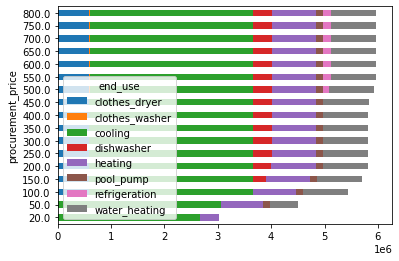

In [26]:
sup = io.get_supply_curve(dem, tou, ren, ts, year=2016, dr_type='shift', disaggregate_by='end_use')
sup.plot.barh(stacked=True)

In [ ]:
models.database.close()